<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Mean-Variance Portfolio Class

Without doubt, the Markowitz (1952) **mean-variance portfolio theory** is a cornerstone of modern financial theory. This section illustrates the use of the `mean_variance_portfolio` class to implement this approach.

In [6]:
from dx import *
import seaborn as sns; sns.set()

## Market Environment and Portfolio Object

We start by instantiating a `market environment` object which in particular contains a list of **ticker symbols** in which we are interested in.

In [7]:
ma = market_environment('ma', dt.date(2010, 1, 1))
ma.add_list('symbols', ['AAPL', 'GOOG', 'MSFT', 'FB'])
ma.add_constant('source', 'google')
ma.add_constant('final date', dt.date(2014, 3, 1))

Using pandas under the hood, the class **retrieves historial stock price data** from either Yahoo! Finance of Google.

In [8]:
%%time
port = mean_variance_portfolio('am_tech_stocks', ma)
  # instantiates the portfolio class
  # and retrieves all the time series data needed

CPU times: user 479 ms, sys: 4.13 ms, total: 484 ms
Wall time: 4.88 s


## Basic Statistics

Since no **portfolio weights** have been provided, the class defaults to equal weights.

In [9]:
port.get_weights()
  # defaults to equal weights

{'AAPL': 0.25, 'FB': 0.25, 'GOOG': 0.25, 'MSFT': 0.25}

Given these weights you can calculate the **portfolio return** via the method `get_portfolio_return`.

In [10]:
port.get_portfolio_return()
  # expected (= historical mean) return

0.19012032495905895

Analogously, you can call `get_portfolio_variance` to get the historical **portfolio variance**.

In [11]:
port.get_portfolio_variance()
  # expected (= historical) variance

0.043145879775030503

The class also has a neatly printable `string` representation.

In [12]:
print(port)
  # ret. con. is "return contribution"
  # given the mean return and the weight
  # of the security

Portfolio am_tech_stocks 
--------------------------
return            0.190
volatility        0.208
Sharpe ratio      0.915

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.250 |     0.054 
GOOG   |  0.250 |     0.040 
MSFT   |  0.250 |     0.013 
FB     |  0.250 |     0.083 



## Setting Weights

Via the method `set_weights` the weights of the single portfolio components can be adjusted.

In [15]:
port.set_weights([0.6, 0.2, 0.1, 0.1])

In [16]:
print port

Portfolio am_tech_stocks 
--------------------------
return            0.201
volatility        0.216
Sharpe ratio      0.927

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.600 |     0.130 
GOOG   |  0.200 |     0.032 
MSFT   |  0.100 |     0.005 
FB     |  0.100 |     0.033 



You cal also easily **check results for different weights** with changing the attribute values of an object.

In [17]:
port.test_weights([0.6, 0.2, 0.1, 0.1])
    # returns av. return + vol + Sharp ratio
    # without setting new weights

array([ 0.20064395,  0.21644491,  0.92699775])

Let us implement a **Monte Carlo simulation** over potential portfolio weights.

In [18]:
# Monte Carlo simulation of portfolio compositions
rets = []
vols = []

for w in range(500):
    weights = np.random.random(4)
    weights /= sum(weights)
    r, v, sr = port.test_weights(weights)
    rets.append(r)
    vols.append(v)

rets = np.array(rets)
vols = np.array(vols)

And the simulation results **visualized**.

<matplotlib.colorbar.Colorbar instance at 0x7f35968cae60>

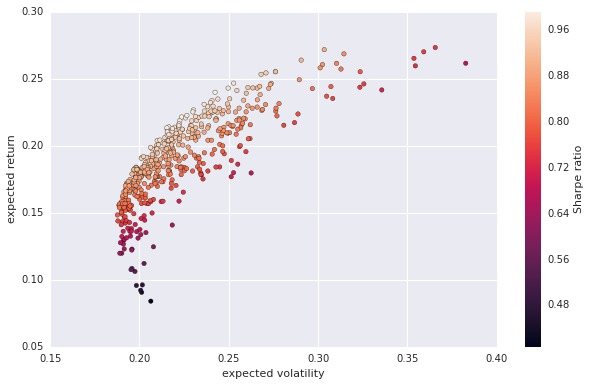

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(vols, rets, c=rets / vols, marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

## Optimizing Portfolio Composition

One of the major application areas of the mean-variance portfolio theory and therewith of this DX Analytics class it the **optimization of the portfolio composition**. Different target functions can be used to this end.

### Return

The first target function might be the **portfolio return**.

In [20]:
port.optimize('Return')
  # maximizes expected return of portfolio
  # no volatility constraint

In [21]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.332
volatility        0.523
Sharpe ratio      0.635

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.000 |     0.000 
GOOG   | -0.000 |     0.000 
MSFT   |  0.000 |     0.000 
FB     |  1.000 |     0.332 



Instead of maximizing the portfolio return without any constraints, you can also set a (sensible/possible) **maximum target volatility** level as a constraint. Both, in an **exact sense** ("equality constraint") ...

In [22]:
port.optimize('Return', constraint=0.225, constraint_type='Exact')
  # interpretes volatility constraint as equality

In [23]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.226
volatility        0.225
Sharpe ratio      1.005

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.481 |     0.104 
GOOG   |  0.294 |     0.047 
MSFT   | -0.000 |     0.000 
FB     |  0.225 |     0.075 



... or just a an **upper bound** ("inequality constraint").

In [24]:
port.optimize('Return', constraint=0.4, constraint_type='Bound')
  # interpretes volatility constraint as inequality (upper bound)

In [25]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.302
volatility        0.400
Sharpe ratio      0.756

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.258 |     0.056 
GOOG   | -0.000 |     0.000 
MSFT   | -0.000 |     0.000 
FB     |  0.742 |     0.246 



### Risk

The class also allows you to minimize **portfolio risk**.

In [26]:
port.optimize('Vol')
  # minimizes expected volatility of portfolio
  # no return constraint

In [27]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.140
volatility        0.187
Sharpe ratio      0.747

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.211 |     0.046 
GOOG   |  0.248 |     0.040 
MSFT   |  0.448 |     0.023 
FB     |  0.093 |     0.031 



And, as before, to set **constraints** (in this case) for the target return level.

In [28]:
port.optimize('Vol', constraint=0.175, constraint_type='Exact')
  # interpretes return constraint as equality

In [29]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.175
volatility        0.194
Sharpe ratio      0.904

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.318 |     0.069 
GOOG   |  0.282 |     0.045 
MSFT   |  0.256 |     0.013 
FB     |  0.143 |     0.048 



In [30]:
port.optimize('Vol', constraint=0.20, constraint_type='Bound')
  # interpretes return constraint as inequality (upper bound)

In [31]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.200
volatility        0.206
Sharpe ratio      0.970

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.397 |     0.086 
GOOG   |  0.301 |     0.048 
MSFT   |  0.123 |     0.006 
FB     |  0.179 |     0.059 



### Sharpe Ratio

Often, the target of the portfolio optimization efforts is the so called **Sharpe ratio**. The `mean_variance_portfolio` class of DX Analytics assumes a **risk-free rate of zero** in this context.

In [34]:
port.optimize('Sharpe')
  # maximize Sharpe ratio

In [35]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.229
volatility        0.228
Sharpe ratio      1.006

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.493 |     0.107 
GOOG   |  0.268 |     0.043 
MSFT   |  0.000 |     0.000 
FB     |  0.238 |     0.079 



## Efficient Frontier

Another application area is to derive the **efficient frontier** in the mean-variance space. These are all these portfolios for which there is **no portfolio with both lower risk and higher return**. The method `get_efficient_frontier` yields the desired results.

In [36]:
%%time
evols, erets = port.get_efficient_frontier(100)
  # 100 points of the effient frontier

CPU times: user 3.15 s, sys: 41.3 ms, total: 3.19 s
Wall time: 3.22 s


The plot with the **random and efficient portfolios**.

<matplotlib.colorbar.Colorbar instance at 0x7f3594e18878>

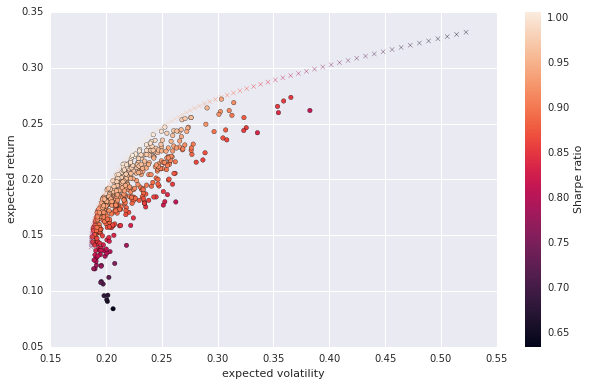

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(vols, rets, c=rets / vols, marker='o')
plt.scatter(evols, erets, c=erets / evols, marker='x')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

## Capital Market Line

The **capital market line** is another key element of the mean-variance portfolio approach representing all those risk-return combinations (in mean-variance space) that are possible to form from a **risk-less money market account** and **the market portfolio** (or another appropriate substitute efficient portfolio).

In [38]:
%%time
cml, optv, optr = port.get_capital_market_line(riskless_asset=0.05)
  # capital market line for effiecient frontier and risk-less short rate

CPU times: user 3.23 s, sys: 5.13 ms, total: 3.24 s
Wall time: 3.24 s


In [39]:
cml  # lambda function for capital market line

<function dx.portfolio.<lambda>>

The following plot illustrates that the capital market line has an ordinate value equal to the **risk-free rate** (the safe return of the money market account) and is tangent to the **efficient frontier**.

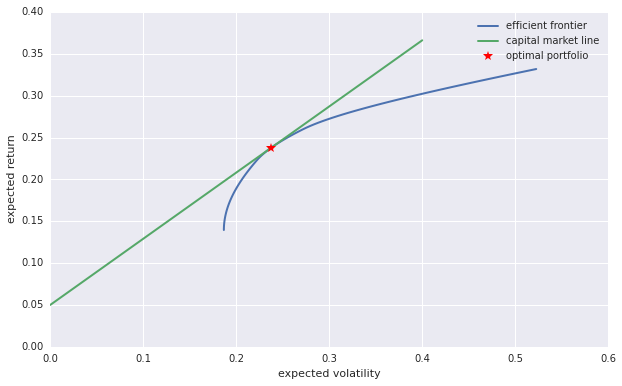

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(evols, erets, lw=2.0, label='efficient frontier')
plt.plot((0, 0.4), (cml(0), cml(0.4)), lw=2.0, label='capital market line')
plt.plot(optv, optr, 'r*', markersize=10, label='optimal portfolio')
plt.legend(loc=0)
plt.ylim(0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

Portfolio return and risk of the efficient portfolio used are:

In [41]:
optr

0.23779804830709764

In [42]:
optv

0.23758786292012518

The **portfolio composition** can be derived as follows.

In [43]:
port.optimize('Vol', constraint=optr, constraint_type='Exact')

In [44]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.238
volatility        0.238
Sharpe ratio      1.001

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.532 |     0.116 
GOOG   |  0.192 |     0.031 
MSFT   |  0.000 |     0.000 
FB     |  0.276 |     0.091 



Or also in this way.

In [45]:
port.optimize('Return', constraint=optv, constraint_type='Exact')

In [46]:
print(port)

Portfolio am_tech_stocks 
--------------------------
return            0.238
volatility        0.238
Sharpe ratio      1.001

Positions
symbol | weight | ret. con. 
--------------------------- 
AAPL   |  0.531 |     0.115 
GOOG   |  0.193 |     0.031 
MSFT   | -0.000 |     0.000 
FB     |  0.276 |     0.092 



## Dow Jones Industrial Average

As a larger, more realistic example, consider **all symbols of the Dow Jones Industrial Average 30 index**.

In [47]:
symbols = ['AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
    'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'T', 'TRV', 'UNH', 'UTX',
    'V', 'VZ','WMT', 'XOM']
  # all DJIA 30 symbols

In [53]:
ma = market_environment('ma', dt.date(2010, 1, 1))
ma.add_list('symbols', symbols)
ma.add_constant('source', 'google')
ma.add_constant('final date', dt.date(2014, 3, 1))

**Data retrieval** in this case takes a bit.

In [58]:
%%time
djia = mean_variance_portfolio('djia', ma)
  # defining the portfolio and retrieving the data

Can not find data for source google and symbol CAT.
Will try other source.


/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


CPU times: user 3.85 s, sys: 52.1 ms, total: 3.9 s
Wall time: 32.1 s


In [59]:
%%time
djia.optimize('Vol')
print(djia.variance, djia.variance ** 0.5)
  # minimium variance & volatility in decimals

(0.011941249866209576, 0.10927602603594978)
CPU times: user 243 ms, sys: 148 µs, total: 243 ms
Wall time: 244 ms


Given the larger data set now used, **efficient frontier** ...

In [60]:
%%time
evols, erets = djia.get_efficient_frontier(25)
  # efficient frontier of DJIA

CPU times: user 13.5 s, sys: 11.7 ms, total: 13.6 s
Wall time: 13.6 s


... and **capital market line** derivations take also longer.

In [61]:
%%time
cml, optv, optr = djia.get_capital_market_line(riskless_asset=0.01)
  # capital market line and optimal (tangent) portfolio

CPU times: user 48.7 s, sys: 27.6 ms, total: 48.7 s
Wall time: 48.7 s


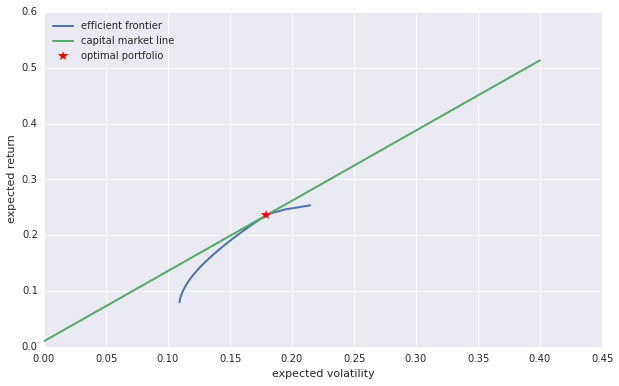

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(evols, erets, lw=2.0, label='efficient frontier')
plt.plot((0, 0.4), (cml(0), cml(0.4)), lw=2.0, label='capital market line')
plt.plot(optv, optr, 'r*', markersize=10, label='optimal portfolio')
plt.legend(loc=0)
plt.ylim(0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)